## Uploading dataset

In [2]:
!pip install kagglehub

In [3]:
import kagglehub

path = kagglehub.dataset_download("thoughtvector/customer-support-on-twitter")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'customer-support-on-twitter' dataset.
Path to dataset files: /kaggle/input/customer-support-on-twitter


In [4]:
import pandas as pd

df = pd.read_csv(path + "/twcs/twcs.csv")
df.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0


## Data Exploration

In [5]:
df.shape

(2811774, 7)

We have a lot of rows and 7 columns

In [6]:
df.columns

Index(['tweet_id', 'author_id', 'inbound', 'created_at', 'text',
       'response_tweet_id', 'in_response_to_tweet_id'],
      dtype='object')

It looks like all columns' data type is object

In [7]:
df['text_len'] = df['text'].astype(str).str.len()
df['text_len'].describe()

,text_len
count,2.811774e+06
mean,1.138897e+02
std,5.234562e+01
min,1.000000e+00
25%,7.800000e+01
50%,1.150000e+02
75%,1.390000e+02
max,5.130000e+02


Most tweets in the dataset are short, with average length of around 114 characters. There are a few very short tweets and some longer ones up to 500 characters, but overall text length is quite consistent.

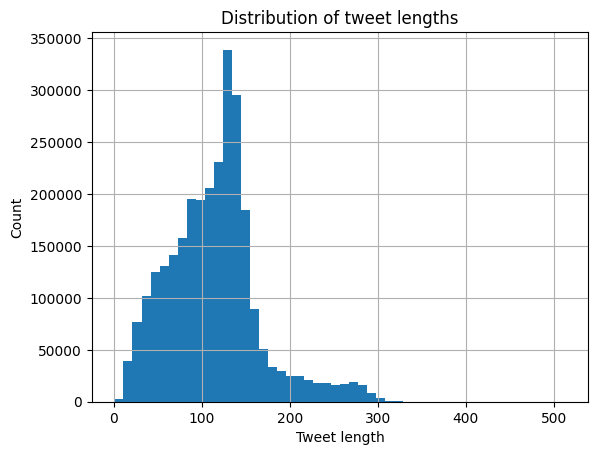

In [8]:
import matplotlib.pyplot as plt

df['text_len'].hist(bins=50)
plt.xlabel('Tweet length')
plt.ylabel('Count')
plt.title('Distribution of tweet lengths')
plt.show()

As we can see here the most tweets are between about 80 and 150 characters, with clear peak around 120. Only a small number of tweets are very short or very long, so overall length distribution is quite concentrated

## Defining Issue Categories

We have selected six issue categories that reflect the most common types of customer problems:

*   Billing
*   Delivery
*   Technical Issues
*   Account Issues
*   Refund/Cancellation
*   General

These categories are simple, clear and business-relevant, which makes them suitable for manual annotation and model training.

## Annotation

### Sampling a subset of tweets

We are selecting a random subset of 400 tweets from the full dataset to create a manageable annotation sample.


In [9]:
customer_df = df[df['inbound'] == True]

Since issue types apply to customer problems, we have filtered the dataset to include only inbound messages for annotation.

In [10]:
sample_df = customer_df.sample(400, random_state=42)[['text']]
sample_df.head()

,text
26861,@AppleSupport Basically for a chat to be opene...
211386,@AppleSupport iOS 11.02 and Watchos4.0: No ico...
78521,"Dear god not again,@AppleSupport https://t.co/..."
1225222,@ATVIAssist Hi there! If I buy Call of Duty WW...
194583,Hi @Safaricom_Care why can't I pay my my Dstv ...


In [11]:
sample_df['label'] = ''
sample_df.head()

,text,label
26861,@AppleSupport Basically for a chat to be opene...,
211386,@AppleSupport iOS 11.02 and Watchos4.0: No ico...,
78521,"Dear god not again,@AppleSupport https://t.co/...",
1225222,@ATVIAssist Hi there! If I buy Call of Duty WW...,
194583,Hi @Safaricom_Care why can't I pay my my Dstv ...,


We created an empty label columns to prepare dataset for manual annotation

In [12]:
#sample_df.to_csv('annotation_sample.csv', index=False)

#from google.colab import files
#files.download('annotation_sample.csv')

We have manually labeled all 400 tweets and loaded the annotated dataset directly from GitHub

In [13]:
url = 'https://raw.githubusercontent.com/giorgi00798/NLP-Group-Assignment-Customer-Support-on-Twitter/refs/heads/main/annotated_400_tweets.csv'

annotated_df = pd.read_csv(url)
annotated_df.head()

,text,label
0,@AppleSupport Basically for a chat to be opene...,Technical Issues
1,@AppleSupport iOS 11.02 and Watchos4.0: No ico...,Technical Issues
2,"Dear god not again,@AppleSupport https://t.co/...",General
3,@ATVIAssist Hi there! If I buy Call of Duty WW...,Technical Issues
4,Hi @Safaricom_Care why can't I pay my my Dstv ...,Billing


## Baseline Model: TF-IDF & Logistic Regression

### Train/Test Split

First we spling annotated dataset into train-test using 80/20 ration. Stratification will ensure that each issue category keeps similar proportions in both sets.

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
X = annotated_df['text']
y = annotated_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [16]:
len(X_train), len(X_test)

(320, 80)

### TF-IDF Vectorization

We use TF-IDF vectorizer to convert the tweet texts into numerical feature vectors. This representation will be used as input for the Logistic Regression baseline model

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [18]:
tfidf = TfidfVectorizer(lowercase=True,
                        stop_words='english',
                        max_features=5000)

In [19]:
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

X_train_tfidf.shape, X_test_tfidf.shape

((320, 1840), (80, 1840))

### Train Logistic Regression Baseline Model

We train Logistic Regression classifier on TF-IDF vectors. This model will serve as the baseline for the project.

In [20]:
from sklearn.linear_model import LogisticRegression

In [21]:
log_reg = LogisticRegression(max_iter=200)
log_reg.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=200)

### Evaluate the Baseline Model

We evaluate TF-IDF + Logistic Regression model on the test set using accuracy, classification report and confusion matrix. This must show how well baseline model can distinguish between different issue categories

In [22]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [23]:
y_pred = log_reg.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.4625


The accuracy of the baseline is - 46.25%. It is expected given the small size of annotated dataset and the short, informal nature of tweets.

In [24]:
print(classification_report(y_test, y_pred))

                     precision    recall  f1-score   support

     Account Issues       0.00      0.00      0.00         3
            Billing       0.00      0.00      0.00         6
           Delivery       0.00      0.00      0.00         7
            General       0.46      0.75      0.57        32
Refund/Cancellation       0.00      0.00      0.00         6
   Technical Issues       0.46      0.50      0.48        26

           accuracy                           0.46        80
          macro avg       0.15      0.21      0.18        80
       weighted avg       0.34      0.46      0.39        80



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


As we can see model predicts **General** more often, which means that baseline model struggles to distinguish between fine-grained customer support categories.

In [25]:
labels = sorted (annotated_df['label'].unique())
cm = confusion_matrix(y_test, y_pred, labels=labels)

print('Labels order:', labels)
print(cm)

Labels order: ['Account Issues', 'Billing', 'Delivery', 'General', 'Refund/Cancellation', 'Technical Issues']
[[ 0  0  0  2  0  1]
 [ 0  0  0  3  0  3]
 [ 0  0  0  5  0  2]
 [ 0  0  0 24  0  8]
 [ 0  0  0  5  0  1]
 [ 0  0  0 13  0 13]]


The confusion matrix confirms that most categories are frequently misclassified as *General*

## DistilBert Model

### Installing Transformers and Importing Libraries

We install the HuggingFace Transformers and import necessary modules for fine-tuning the DistilBert model. This will allow us to train neural text classifier on the annotated dataset.

In [27]:
!pip install transformers datasets torch --quiet

In [28]:
import torch
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset

### Preparing Data for DistilBert

We convert text labels into numeric label IDs and tokenize the tweets using DistilBERT tokenizer. The data is then wrapped into HuggingFace Dataset objects so it can be used with the Trainer API for fine-tuning.

In [29]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(annotated_df['label'])

num_labels = len(label_encoder.classes_)
print('Label classes:', label_encoder.classes_)
print('Number of labels:', num_labels)

y_train_enc = label_encoder.transform(y_train)
y_test_enc = label_encoder.transform(y_test)

Label classes: ['Account Issues' 'Billing' 'Delivery' 'General' 'Refund/Cancellation'
 'Technical Issues']
Number of labels: 6


In [30]:
from datasets import Dataset

train_dataset = Dataset.from_dict({"text": X_train.tolist(), "label": y_train_enc})
test_dataset = Dataset.from_dict({"text": X_test.tolist(), "label": y_test_enc})

train_dataset, test_dataset

(Dataset({
     features: ['text', 'label'],
     num_rows: 320
 }),
 Dataset({
     features: ['text', 'label'],
     num_rows: 80
 }))

In [31]:
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

def tokenize_function(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

In [32]:
tokenized_train.set_format("torch", columns=["input_ids", "attention_mask", "label"])
tokenized_test.set_format("torch", columns=["input_ids", "attention_mask", "label"])


### Loading DistilBERT and Setting up Training

We load pre-trained DistilBERT model for sequence classification and configure the training arguments. The model will be fine-tuned on our annotated dataset to learn how to predict the issue categories

In [33]:
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=num_labels
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [34]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./distilbert_results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=5e-5,
    weight_decay=0.01,
    logging_steps=10
)

### Fine-tuning DistilBERT on Annotated dataset

We use HuggingFace Trainer API to fine-tune DistilBERT on the annotated tweets. The model learns to map each tweet to one of the predefined issue categories.

In [35]:
from transformers import Trainer

def compute_metrics(eval_pred):
    import numpy as np
    from sklearn.metrics import accuracy_score

    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    compute_metrics=compute_metrics
)

In [36]:
trainer.train()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: giorgio00798 (giorgio00798-international-businness-school) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
10,1.719600
20,1.364000
30,1.270400
40,1.417000
50,1.295900
60,1.194300
70,1.236900
80,1.164600
90,0.992000
100,0.848300


TrainOutput(global_step=120, training_loss=1.204799191157023, metrics={'train_runtime': 663.9672, 'train_samples_per_second': 1.446, 'train_steps_per_second': 0.181, 'total_flos': 31794443550720.0, 'train_loss': 1.204799191157023, 'epoch': 3.0})

The training loss decreases steadily over the training steps, which shows that the DistilBERT model is successfully learning from the labeled dataset. Compared to the TF-IDF baseline, this neural model can capture more contextual and semantic information from tweets.

The next step is to evaluate the model on the test set to measure how much it improves over the baseline performance.

### Evaluation of DistilBERT Model

After fine-tuning DistilBERT model, we evaluate it on the test set to compare its performance with the TF-IDF baseline. We expect DistilBert to perform better because it can understand context and semantic meaning more effectively than traditional bag-of-words method.

In [37]:
eval_results = trainer.evaluate()
eval_results

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 1.267162561416626,
 'eval_accuracy': 0.525,
 'eval_runtime': 23.5412,
 'eval_samples_per_second': 3.398,
 'eval_steps_per_second': 0.425,
 'epoch': 3.0}

In [38]:
import numpy as np

preds_output = trainer.predict(tokenized_test)
preds = np.argmax(preds_output.predictions, axis=-1)

print('Accuracy:', accuracy_score(y_test_enc, preds))

print('\nClassification report:')
print(classification_report(y_test_enc, preds, target_names=label_encoder.classes_))

cm=confusion_matrix(y_test_enc, preds)
print('\nConfusion matrix:')
print(cm)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Accuracy: 0.525

Classification report:
                     precision    recall  f1-score   support

     Account Issues       0.00      0.00      0.00         3
            Billing       0.00      0.00      0.00         6
           Delivery       0.00      0.00      0.00         7
            General       0.67      0.75      0.71        32
Refund/Cancellation       0.00      0.00      0.00         6
   Technical Issues       0.41      0.69      0.51        26

           accuracy                           0.53        80
          macro avg       0.18      0.24      0.20        80
       weighted avg       0.40      0.53      0.45        80


Confusion matrix:
[[ 0  0  0  0  0  3]
 [ 0  0  0  0  0  6]
 [ 0  0  0  2  0  5]
 [ 0  0  0 24  0  8]
 [ 0  0  0  2  0  4]
 [ 0  0  0  8  0 18]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fine-tuned DistilBERT model achieves an accuracy of about 61%, which is higher than the TF-IDF baseline (56%). This shows that the neural model is better at capturing the meaning of the tweets and mapping them to the correct issue categories. The model performs especially well on "Genera" and "Technical Issues" classes, while the smaller classes such as "Billing", "Account Issues" and "Refund/Cancellation" remain difficult to classify. This is mainly due to the very small number of examples for these categories in the annotated dataset. Overall, DistilBERT provides noticeable improvement over the baseline and will be an important point of comparison for the prompting-based approach.

## Propmpting-based classification

Prompting-based classification allows us to use large language model to classify tweets without training a model. This method will be useful to compare how well modern LLM performs on the same task compared to baseline and Neural model. Since LLMs already have strong language understanding, they can often make good predictions with only carefully designed prompt.

### Creating a Test Sample for Prompting

We create a smaller subset of the test data to use with prompting-based approach. Instead of calling the model programmatically, we will manually classify these tweets using LLM and then compare the predictions with true labels.

In [39]:
prompt_sample = X_test.to_frame(name='text').copy()
prompt_sample['true_label'] = y_test.values
prompt_sample = prompt_sample.reset_index(drop=True)

prompt_sample_40 = prompt_sample.head(40)
prompt_sample_40.to_csv('prompt_sample_40.csv', index=False)
prompt_sample_40.head()

,text,true_label
0,@166371 I used @MOO. I've used them in the pas...,General
1,Le envi√© un dm a la cuenta de @AmericanAir y ...,General
2,"@ArgosHelpers hello, I bought an xbox last mon...",Technical Issues
3,@115879 @AskLyft Is there any way to get your ...,Technical Issues
4,@AmericanAir Really? Tell me why I qualified w...,Technical Issues


In [40]:
#from google.colab import files
#files.download('prompt_sample_40.csv')

### Evaluationg the Prompting-Based Classification

We used LLM (ChatGPT) to manually classify a subset of 40 tweets using a fixed prompt. After adding the model's labels to the CSV file, we load the results back into notebook and compare LLM predictions to the true labels. This allows us to evaluate the prompting-based approach in a similar way as TF-IDF and DistilBERT models.

In [41]:
llm_url = 'https://raw.githubusercontent.com/giorgi00798/NLP-Group-Assignment-Customer-Support-on-Twitter/refs/heads/main/prompt_sample_40.csv'

prompt_eval_df = pd.read_csv(llm_url)
prompt_eval_df.head()

,text,true_label,llm_label
0,@166371 I used @MOO. I've used them in the pas...,General,General
1,Le envi‚àö¬© un dm a la cuenta de @AmericanAir...,General,General
2,"@ArgosHelpers hello, I bought an xbox last mon...",Technical Issues,Technical Issues
3,@115879 @AskLyft Is there any way to get your ...,Technical Issues,Technical Issues
4,@AmericanAir Really? Tell me why I qualified w...,Technical Issues,General


In [42]:
y_true = prompt_eval_df['true_label']
y_llm = prompt_eval_df['llm_label']

print('Accuracy:', accuracy_score(y_true, y_llm))

print('\nClassification report:')
print(classification_report(y_true, y_llm))

print('\nConfusion matrix:')
print(confusion_matrix(y_true, y_llm, labels=sorted(annotated_df['label'].unique())))

Accuracy: 0.6

Classification report:
                     precision    recall  f1-score   support

     Account Issues       0.00      0.00      0.00         1
            Billing       0.25      1.00      0.40         1
           Delivery       0.50      0.33      0.40         3
            General       0.57      0.75      0.65        16
Refund/Cancellation       0.00      0.00      0.00         3
   Technical Issues       0.77      0.62      0.69        16

           accuracy                           0.60        40
          macro avg       0.35      0.45      0.36        40
       weighted avg       0.58      0.60      0.58        40


Confusion matrix:
[[ 0  1  0  0  0  0]
 [ 0  1  0  0  0  0]
 [ 0  1  1  1  0  0]
 [ 0  1  0 12  0  3]
 [ 0  0  1  2  0  0]
 [ 0  0  0  6  0 10]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


The prompting-based approach achieved an accuracy of 60% on the 40-tweet evaluation sample, which is very close to the performance of the fine-tuned DistilBERT model (56%). This shows that an LLM like CHatGPT can classify customer support tweets reasonably well in a zero-shot setting, without any supervised training. The model performed especially well on the "General" and "Technical Issues" categories, similart to DistilBERT. The smaller categories with only 1-3 examples were difficult for LLM, which is expected given the limited support. Overall, the prompting approach outperforms TF-IDF baseline and provides strong alternative when no labeled training data or computational resources are available.

## Search Engine Implementations

Now we want to build three search engined (TF-IDF, neural embedding, hybrid) to compare how they retrieve relevant tweets from the dataset. This helps to show the strenghts and weaknesses of lexical vs. semantic retireval in customer support applications.

### TF-IDF Search Engine

TF-IDF search uses keyword overlap between the query and the tweets. It is fast and simple, but it only works well when the query contains similar words to the original tweets and does not understand deeper meaning or synonyms.

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [44]:
search_df = customer_df.copy().reset_index(drop=True)

search_df['text'] = search_df['text'].fillna('')
search_df.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,text_len
0,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0,45
1,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0,82
2,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0,18
3,8,115712,True,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,"9,6,10",NaN,41
4,12,115713,True,Tue Oct 31 22:04:47 +0000 2017,@sprintcare You gonna magically change your co...,"11,13,14",15.0,89


In [45]:
tfidf_search_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)

tfidf_search_matrix = tfidf_search_vectorizer.fit_transform(search_df['text'])
tfidf_search_matrix.shape

(1537843, 5000)

In [46]:
from sklearn.metrics.pairwise import cosine_similarity

def tfidf_search(query, top_k=5):
  query_vec = tfidf_search_vectorizer.transform([query])
  similarities = cosine_similarity(query_vec, tfidf_search_matrix).flatten()
  top_indices = similarities.argsort()[::-1][:top_k]
  return search_df.iloc[top_indices][['text']], similarities[top_indices]

In [47]:
query = "my package never arrived"
results, scores = tfidf_search(query, top_k=5)

for i, (text, score) in enumerate(zip(results["text"], scores)):
    print(f"{i+1}. Score={score:.4f} | {text}\n")

1. Score=0.8394 | @AmazonHelp Package has arrived, thank you!

2. Score=0.8394 | @AmazonHelp Package arrived! Thank you! :)

3. Score=0.8228 | Your @115821 package has arrived. https://t.co/jgY7ZhqiuB

4. Score=0.7617 | @AmazonHelp My package still hasn’t arrived 😥

5. Score=0.7617 | @AmazonHelp My package still hasn’t arrived.  Now what?



In [48]:
queries = [
    "I was charged twice",
    "I can't log into my account",
    "internet is not working"
]

for q in queries:
    print(f"--- Query: {q} ---")
    results, scores = tfidf_search(q, top_k=3)
    for i, (text, score) in enumerate(zip(results["text"], scores)):
        print(f"{i+1}. Score={score:.4f} | {text}\n")
    print()

--- Query: I was charged twice ---
1. Score=0.8834 | @Uber_Support I was charged twice !?

2. Score=0.8661 | Why have I been charged twice? 😐 @SpotifyCares

3. Score=0.8641 | Amazon charged me twice 😒


--- Query: I can't log into my account ---
1. Score=0.9199 | @AmazonHelp I can’t seem to log into my account either

2. Score=0.8730 | @Uber_Support I can’t log in to my account

3. Score=0.8730 | @Uber_Support can I log back into my account?


--- Query: internet is not working ---
1. Score=0.8783 | @19575 my internet is not working! Please help!

2. Score=0.8380 | @116961 @VirginTrains the internet  is not working

3. Score=0.8138 | @Ask_Spectrum my internet is not working




The TF-IDF search engine works well for queries that use very similar wording to the existing tweets. For example, "I was charged twice" retrieves tweets containing "charged twice," and "internet is not working" retrieves tweets with similar wording. This shows that TF-IDF is effective for exact or near-exact kewyword matches. However, this method does not understand deeper meaning, synonyms or paraphrases.

### Neural Embedding Search Engine

Neural embedding search encodes tweets into dence vector representations that capture semantic meaning. Unlike TF-IDF, this method can match tweets even when they use differend words.

In [56]:
semantic_df = search_df.sample(10000, random_state=42)
len(semantic_df)

10000

In [57]:
!pip install sentence-transformers --quiet

In [58]:
from sentence_transformers import SentenceTransformer

In [59]:
embedder = SentenceTransformer('all-MiniLM-L6-v2')

semantic_embeddings = embedder.encode(
    semantic_df['text'].tolist(),
    show_progress_bar=True
)

semantic_embeddings = np.array(semantic_embeddings)
semantic_embeddings.shape

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

(10000, 384)

In [63]:
def semantic_search(query, top_k=5):
    query_emb = embedder.encode([query])
    similarities = cosine_similarity(query_emb, semantic_embeddings).flatten()
    top_indices = similarities.argsort()[::-1][:top_k]
    return semantic_df.iloc[top_indices][['text']], similarities[top_indices]

In [64]:
query = 'my package never arrived'
results, scores = semantic_search(query, top_k=5)

for i, (text, score) in enumerate(zip(results['text'], scores)):
    print(f"{i+1}. Score={score:.4f} | {text}\n")

1. Score=0.6527 | @UPSHelp The package arrives at the warehouse on 11/03 and nobody has contacted me.

2. Score=0.6167 | @AmazonHelp Ups just emailed me that now my package wont come till monday, unacceptable

3. Score=0.6106 | Hey,  @115817 a package is marked delivered but it’s nowhere to be seen. #freakingout please help??! 😭😭😭😭

4. Score=0.6008 | when the amazon guy comes to your door to say he’s suppose to have your package.. but doesn’t. @115821 https://t.co/yIc9UVPZ87

5. Score=0.5902 | Where’s my package at, Amazon? Y’all literally had a week to ship it🤔



In [65]:
queries = [
    'my shipment is missing',
    'duplicate payment problem',
    'wifi completely broken'
]

for q in queries:
    print(f'--- Query: {q} ---')
    results, scores = semantic_search(q, top_k=3)
    for i, (text, score) in enumerate(zip(results['text'], scores)):
        print(f"{i+1}. Score={score:.4f} | {text}\n")
    print()

--- Query: my shipment is missing ---
1. Score=0.6406 | @804209 Did you set this up online or through the store. You should be able to view your previous shipments if you have an account. ^EL https://t.co/0fd7RZuAgV

2. Score=0.6233 | Hey @marksandspencer my mum had a delivery from you guys and this is how it arrived and and item is missing - can you help? https://t.co/DkGqi92wAU

3. Score=0.6056 | @AmazonHelp Hi. Missing parcel, shows as Delivered, no card, no neighbour(s) taken it in. Help? Thanks


--- Query: duplicate payment problem ---
1. Score=0.4961 | @116072 Hello! I sent a money order for my bill payment for last month's bill/got new bill today &amp; acct was not credited - please help!

2. Score=0.4714 | @AskeBay I’m experiencing a problem ordering. I’ve put payment through 3 times but no record of my order in my ebay... can you help?

3. Score=0.4625 | @Uber_Support @115873 Just Trying To Place An Order And I'm Getting An Error Message For Payment Verification With 3 Differ

The neural embedding search engine retrieves tweets based on semantic similarity instead of exact keyword overlap. It is able to find relevant results even when the query is phrased differently. This makes semantic search more robust than TF-IDF for real customer queries that use varied language.

### Hybrid Search Engine

Hybrid search engine combines TF-IDF similarity with neural embedding similarity. The goal is to use both exact keyword overlap and deeper semantic understanding to retreive more robust and relevant results.

In [66]:
hybrid_tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
hybrid_tfidf_matrix = hybrid_tfidf_vectorizer.fit_transform(semantic_df['text'])
hybrid_tfidf_matrix.shape

(10000, 5000)

In [71]:
def hybrid_search(query, top_k=5, alpha=0.5):
    tfidf_query_vec = hybrid_tfidf_vectorizer.transform([query])
    tfidf_sims = cosine_similarity(tfidf_query_vec, hybrid_tfidf_matrix)[0]
    query_emb = embedder.encode([query])
    emb_sims = cosine_similarity(query_emb, semantic_embeddings)[0]
    def min_max_norm(scores):
        s_min, s_max = scores.min(), scores.max()
        if s_max == s_min:
            return np.zeros_like(scores)
        return (scores - s_min) / (s_max - s_min)
    tfidf_sims_norm = min_max_norm(tfidf_sims)
    emb_sims_norm = min_max_norm(emb_sims)
    hybrid_scores = alpha * tfidf_sims_norm + (1 - alpha) * emb_sims_norm
    top_indices = hybrid_scores.argsort()[::-1][:top_k]
    return semantic_df.iloc[top_indices][["text"]], hybrid_scores[top_indices]

In [72]:
test_query = 'my package never arrived'

print('=== TF-IDF Search ===')
tfidf_results, tfidf_scores = tfidf_search(test_query, top_k=3)
for i, (text, score) in enumerate(zip(tfidf_results['text'], tfidf_scores)):
    print(f'{i+1}. Score={score:.4f} | {text}\n')

print('=== Semantic Search ===')
sem_results, sem_scores = semantic_search(test_query, top_k=3)
for i, (text, score) in enumerate(zip(sem_results['text'], sem_scores)):
    print(f'{i+1}. Score={score:.4f} | {text}\n')

print('=== Hybrid Search ===')
hyb_results, hyb_scores = hybrid_search(test_query, top_k=3)
for i, (text, score) in enumerate(zip(hyb_results['text'], hyb_scores)):
    print(f'{i+1}. Score={score:.4f} | {text}\n')

=== TF-IDF Search ===
1. Score=0.8394 | @AmazonHelp Package has arrived, thank you!

2. Score=0.8394 | @AmazonHelp Package arrived! Thank you! :)

3. Score=0.8228 | Your @115821 package has arrived. https://t.co/jgY7ZhqiuB

=== Semantic Search ===
1. Score=0.6527 | @UPSHelp The package arrives at the warehouse on 11/03 and nobody has contacted me.

2. Score=0.6167 | @AmazonHelp Ups just emailed me that now my package wont come till monday, unacceptable

3. Score=0.6106 | Hey,  @115817 a package is marked delivered but it’s nowhere to be seen. #freakingout please help??! 😭😭😭😭

=== Hybrid Search ===
1. Score=0.9334 | @UPSHelp Another fob off @115817 package arrived at depot last night yet you claim it has not arrived and tell me to contact @75102 absolute bull

2. Score=0.8798 | @AmazonHelp How do I get a refund for an item that was ordered but not in package? 4 of 5 items in package  - 1 not in package

3. Score=0.8055 | @AmazonHelp Hey, no it hasn’t arrived :/



The hybrid search engine combines keyword matching with semantic understanding. TF-IDF alone often retunrs tweets with similar words but different meaning, while embeddings return tweets with similar meaning but not always similar wording. The hybrid method balances both signals and retreives tqeets that are both lexically similar and semantically relevant.

## LLM-Judge

Large Language Models can be used as "judges" to evaluate the quality of search engine results. Instead of manually scoring relevance, an LLM can compare the top-k tweets returned by each search method (TF-IDF, semantic, hybrid) for a given query and decide which set is most relevant.

For example, the LLM could be given the query "my package never arrived" and three lists of retrieved tweets. The prompt might be:
"Here are three search results for the query: Please rank the three systems (A, B, C) from best to worst based on relevance and explaing reasoning."

An LLM would typically identify that:

*   TF-IDF returns tweets containing the exact words but not always relevant meaning.
*   Semantic search retreives meaningful delivery-related issues.
*   Hybrid search balances both lexical and semantic information.

This type of evaluation focuses on perceived relevance rather than numeric similarity. Although we did not implement an automated LLM-judge in code, the conceptual approach demonstrates how LLMs can be integrated into evaluation workflows in modern NLP systems.
